In [37]:
import pandas as pd
from tensorflow.keras import layers, models, regularizers
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import backend as K

In [38]:
path_csvs = "D:/mestrado/notebooks/dados/features_csv"
cols_to_scale = ['RMSE', 'ZCR', 'COEF_1', 'COEF_2', 'COEF_3', 'COEF_4', 'COEF_5', 'COEF_6', 'COEF_7', 'COEF_8', 'COEF_9', 'COEF_10', 'COEF_11', 'COEF_12', 'COEF_13', 'COEF_14', 'COEF_15', 'COEF_16', 'COEF_17', 'COEF_18', 'COEF_19', 'COEF_20']

In [39]:
df_masculino_completo_normalizado = pd.read_csv("D:/mestrado/notebooks/dados/features_csv/masculino_completo_normalizado.csv", sep=";")


### Criando Tensor

In [40]:
def dataframe_to_tensor(df, num_features):
    grouped = df.groupby("Audio")
    # Cria uma lista de arrays, um para cada áudio
    tensors = [group.iloc[:, :num_features].values for _, group in grouped]
    return np.array(tensors)  # Converte para um tensor 3D

In [41]:
# Função para padronizar as sequências (com padding ou truncamento)
def standardize_frames(sequences, max_frames):
    standardized_sequences = []
    for seq in sequences:
        if len(seq) < max_frames:
            # Padding: Adiciona zeros ao final da sequência
            padded_seq = np.pad(seq, ((0, max_frames - len(seq)), (0, 0)), mode='constant')
            standardized_sequences.append(padded_seq)
        else:
            # Truncamento: Corta a sequência para o tamanho máximo
            truncated_seq = seq[:max_frames, :]
            standardized_sequences.append(truncated_seq)
    return np.array(standardized_sequences)

In [42]:
grouped = df_masculino_completo_normalizado.groupby("Audio")
df_frames = pd.DataFrame()
df_frames['frames'] = df_masculino_completo_normalizado.groupby("Audio").size()

In [43]:
df_frames.head()
print(df_frames['frames'].sum())
numero_max_frames = int(df_frames['frames'].mean())

214221


In [44]:
def extract_y(df):
    num_features = 23  # RMS (1) + ZCR (1) + 20 MFCCs
    grouped = df.groupby("Audio")

    # Converta cada áudio para uma matriz (frames x features)
    sequences = [group.iloc[:, :num_features].values for _, group in grouped]

    # Padronize os frames
    max_frames = numero_max_frames  # Defina o número fixo de frames
    tensor = standardize_frames(sequences, max_frames)

    print("Shape do tensor:", tensor.shape)  # Deve ser (num_audios, max_frames, num_features)

    y = []
    for s in sequences:
        for element in s[0]:
            if isinstance(element, str): 
                if 'saudavel' in element:
                        y.append(0)
                else:
                    y.append(1)
                break

    print(len(y))

    return np.array(y)


In [45]:
def extract_tensor_x(df):
    num_features = 22  # RMS (1) + ZCR (1) + 20 MFCCs
    # Agrupe o DataFrame por áudio
    grouped = df.groupby("Audio")

    # Converta cada áudio para uma matriz (frames x features)
    sequences = [group.iloc[:, :num_features].values for _, group in grouped]

    # Padronize os frames
    max_frames = numero_max_frames  # Defina o número fixo de frames
    tensor = standardize_frames(sequences, max_frames)

    print("Shape do tensor:", tensor.shape)  # Deve ser (num_audios, max_frames, num_features)
    return tensor


### Criando a Rede Neural

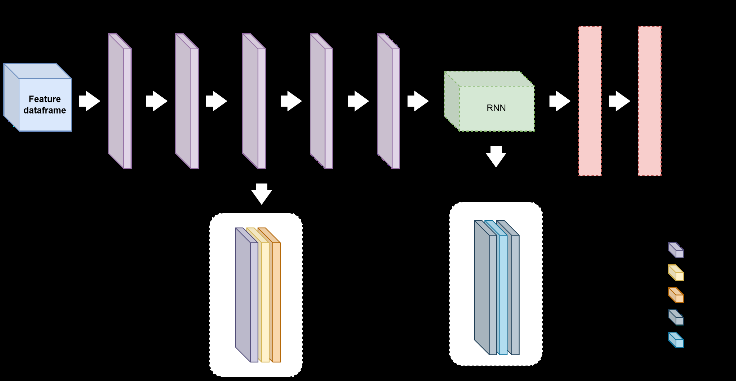

In [46]:
def generate_model():
    # Dimensão das features (exemplo: 20 MFCCs + RMS + ZCR -> 22 features por timestep)
    input_shape = (None, 22)  # None -> Sequência variável, 22 -> Features por timestep

    # Regularização L2 (lambda = 0.01)
    l2_reg = regularizers.L2(0.01)

    # Entrada
    inputs = layers.Input(shape=input_shape)

    # 5 Blocos CNN
    x = inputs
    for _ in range(5):
        x = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2_reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.3)(x)  # Dropout adicional

    # LSTM com regularização L2
    x = layers.LSTM(128, return_sequences=True, kernel_regularizer=l2_reg)(x)

    # Camada de Atenção
    attention = layers.Dense(1, activation="tanh", kernel_regularizer=l2_reg)(x)  # Escore de atenção
    attention = layers.Flatten()(attention)  # Remove dimensão extra
    attention = layers.Activation("softmax")(attention)  # Probabilidade
    attention = layers.RepeatVector(128)(attention)  # Ajusta dimensão para aplicar
    attention = layers.Permute([2, 1])(attention)  # Transposição

    x = layers.Multiply()([x, attention])  # Aplicação da atenção
    x = layers.LSTM(128, kernel_regularizer=l2_reg)(x)  # Resumo da sequência com LSTM final

    # Camadas densas para classificação com regularização e Dropout
    x = layers.Dense(64, activation="relu", kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer=l2_reg)(x)  # Saída binária

    # Construção do modelo
    model = models.Model(inputs, outputs)

    # Compilação
    # Learning Rate default do Adam = 0.001
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "binary_accuracy", "precision", "recall"])
    return model

# Resumo do modelo
model_cnn_rnn = generate_model()
model_cnn_rnn.summary()


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, None, 22)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_120 (Conv1D) │ (None, None, 64)  │      4,288 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_120[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_90    │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_142         │ (None, None, 64)  │          0 │ max_pooling1d_90… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_121 (Conv1D) │ (None, None, 64)  │     12,352 │ dropout_142[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_121[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_91    │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_143         │ (None, None, 64)  │          0 │ max_pooling1d_91… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_122 (Conv1D) │ (None, None, 64)  │     12,352 │ dropout_143[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_122[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_92    │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_144         │ (None, None, 64)  │          0 │ max_pooling1d_92… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_123 (Conv1D) │ (None, None, 64)  │     12,352 │ dropout_144[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_123[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_93    │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_145         │ (None, None, 64)  │          0 │ max_pooling1d_93… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_124 (Conv1D) │ (None, None, 64)  │     12,352 │ dropout_145[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 293,826 (1.12 MB)

 Trainable params: 293,186 (1.12 MB)

 Non-trainable params: 640 (2.50 KB)

In [48]:
# dividindo tensor entre treino, validação e teste
X = extract_tensor_x(df_masculino_completo_normalizado)
y = extract_y(df_masculino_completo_normalizado)

assert len(y) == 2000
assert X.shape[0] == len(y)


Shape do tensor: (2000, 107, 22)
Shape do tensor: (2000, 107, 23)
2000


In [49]:
reduce_lr = ReduceLROnPlateau(
    monitor="loss",  # Monitorar a perda da validação
    factor=0.5,  # Reduz o LR pela metade
    patience=3,  # Espera 3 épocas sem melhora antes de reduzir
    min_lr=1e-6,  # LR mínimo para evitar valores muito pequenos
    verbose=1  # Exibir mensagens quando o LR for reduzido
)

### 10-fold cross-validation

In [50]:
# Geração de dados simulados (substitua pelos seus dados)
np.random.seed(42)

# Parâmetros
k = 10  # Número de folds
num_epochs = 20
batch_size = 32
test_size = 0.3  # Porcentagem para o conjunto de teste

train_accuracies = np.zeros((k, num_epochs))
val_accuracies = np.zeros((k, num_epochs))

# Dividindo os dados em treino+validação e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Configurando o K-Fold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lista para armazenar as métricas de cada fold
fold_losses = []
fold_accuracies = []
fold_binary_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
histories = []

# k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"\nFold {fold+1}/{k}")
    
    # Dividindo os índices para treino e validação
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
    
    # Criando o modelo
    model = generate_model()
    
    # Early stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Configuração do ModelCheckpoint
    checkpoint_callback = ModelCheckpoint(
        filepath='/checkpoints/implementacao/masculino_doente_saudavel_melhor_modelo.keras',      # Caminho onde o modelo será salvo
        monitor='val_loss',               # Métrica monitorada (ex: val_loss ou val_accuracy)
        save_best_only=True,              # Salva apenas o melhor modelo
        save_weights_only=False,          # Salva o modelo completo, incluindo arquitetura
        mode='min',                       # Modo de monitoramento (min para loss, max para accuracy)
        verbose=1                         # Exibe mensagens quando o modelo é salvo
    )
    
    # Treinando o modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint_callback],
        verbose=1
    )

    # Salvar as acurácias
    train_accuracies[fold] = history.history['accuracy']
    val_accuracies[fold] = history.history['val_accuracy']
    
    # Avaliando no conjunto de validação
    val_loss, val_accuracy, val_binary_accuracy, val_precision, val_recall = model.evaluate(X_val, y_val, verbose=1)
    print(f"Validação - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)
    fold_binary_accuracies.append(val_binary_accuracy)
    fold_precisions.append(val_precision)
    fold_recalls.append(val_recall)
    #fold_f1_scores.append(val_f1_score)
    histories.append(history)

# Avaliação final no conjunto de treino
print("\nCross-validation completado.")
print(f"Accuracies por fold: {fold_accuracies}")
print(f"Accuracy média: {np.mean(fold_accuracies):.4f}, Desvio padrão: {np.std(fold_accuracies):.4f}")


Fold 1/10
Epoch 1/20
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5673 - binary_accuracy: 0.5673 - loss: 6.2949 - precision: 0.5483 - recall: 0.7612
Epoch 1: val_loss improved from inf to 3.03788, saving model to /checkpoints/implementacao/masculino_doente_saudavel_melhor_modelo.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5828 - binary_accuracy: 0.5828 - loss: 6.1719 - precision: 0.5604 - recall: 0.7706 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000 - val_loss: 3.0379 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
36/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9496 - binary_accuracy: 0.9496 - loss: 2.2680 - precision: 0.9599 - recall: 0.9388
Epoch 2: val_loss improved from 3.03788 to 1.73295, saving model to /checkpoints/implementacao/masculino_doente_saudavel_melhor_modelo.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9506 - binary_accuracy: 0.9506 - loss: 2.2140 - precision: 0.9604 - recall: 0.9401 - val_accuracy: 0

In [51]:
# Avaliando o modelo no conjunto de teste
histories_teste = []
test_losses = []
test_accuracies = []
test_binary_accuracies = []
test_precisions = []
test_recalls = []

for i in range(10):
    final_model = generate_model()
    # history_final = final_model.fit(X_train_val, y_train_val, epochs=num_epochs, batch_size=batch_size, verbose=1)
    history_final = final_model.fit(X_train_val, y_train_val, epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True), reduce_lr])
    histories_teste.append(history_final)
    test_loss, test_accuracy, test_binary_accuracy, test_precision, test_recall = final_model.evaluate(X_test, y_test, verbose=0)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_binary_accuracies.append(test_binary_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
   
    print("Teste ", i + 1)
    print(f"Desempenho no conjunto de teste - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Binary Accuracy: {test_binary_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

print('test_accuracies')
print(test_accuracies)
print()
print('test_binary_accuracies')
print(test_binary_accuracies)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6803 - binary_accuracy: 0.6803 - loss: 0.7127 - precision: 0.6998 - recall: 0.5648 - learning_rate: 5.0000e-04
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9629 - binary_accuracy: 0.9629 - loss: 0.4218 - precision: 0.9576 - recall: 0.9681 - learning_rate: 5.0000e-04
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9859 - binary_accuracy: 0.9859 - loss: 0.2823 - precision: 0.9833 - recall: 0.9872 - learning_rate: 5.0000e-04
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9854 - binary_accuracy: 0.9854 - loss: 0.2031 - precision: 0.9799 - recall: 0.9900 - learning_rate: 5.0000e-04
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9895 - binary_accuracy: 0.9895 - loss: 0.1530 - precision: 0.9947 - recall: 0.9835 - learning_rate: 5.0000e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9949 - binary_accuracy: 0.9949 - loss: 0.1210 - precisi

In [ ]:
for h in histories:
    print(h.history['accuracy'])

In [ ]:
print(f"Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}")

In [ ]:
path_modelos = "D:/mestrado/notebooks/modelos"
final_model.save(path_modelos + "/" + "model_cnn_rnn_masculino.keras")
final_model.save(path_modelos + "/" + "model_cnn_rnn_masculino.h5")
final_model.save_weights(path_modelos + "/" + "model_cnn_rnn_masculino_pesos.weights.h5")

In [ ]:
path_to_save = "/implementacao/model_cnn_rnn_masculino_history_10_fold"

df_concatenado = pd.DataFrame()
for i in range(0, len(histories)):
    df_aux = pd.DataFrame(histories[i].history)
    if( i > 0):
        df_aux = df_aux.rename(columns={"precision_{}".format(i) : "precision", "val_precision_{}".format(i) : "val_precision", "recall_{}".format(i) : "recall", "val_recall_{}".format(i) : "val_recall"})

    df_aux["k_folder"] = i + 1
    df_concatenado = pd.concat([df_concatenado, df_aux], ignore_index=True)

df_concatenado.to_csv("D:/mestrado/notebooks/historicos{}{}".format(path_to_save, ".csv"), index=False)


print("DataFrame com historicos do k_fold salvo em arquivo.csv com sucesso!")

In [57]:
path_historicos_implementacao = "D:/mestrado/notebooks/historicos/implementacao"

In [58]:
# Salvar o histórico com pickle
with open(path_historicos_implementacao + '/' + 'model_cnn_rnn_masculino_history_final.pkl', 'wb') as file:
    pickle.dump(history_final.history, file)


In [59]:
for i in range(k):
    path = path_historicos_implementacao + '/' + 'model_cnn_rnn_masculino_history_fold_' + str(i) + '.pkl'
    with open(path, 'wb') as file:
        pickle.dump(history_final.history, file)

### Gráficos

In [ ]:
# Calcular a média e o desvio padrão
mean_train_accuracy = np.mean(train_accuracies, axis=0)
mean_val_accuracy = np.mean(val_accuracies, axis=0)
std_val_accuracy = np.std(val_accuracies, axis=0)

# Plotar as curvas de acurácia
plt.figure(figsize=(10, 6))
plt.plot(mean_train_accuracy, label='Acurácia média no treino', color='navy')
plt.plot(mean_val_accuracy, label='Acurácia média na validação', color='steelblue')
plt.fill_between(range(num_epochs),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='steelblue', alpha=0.2, label='Desvio padrão na validação')
plt.title('Acurácias Médias de Treino e Validação ao longo das épocas e folds')
plt.xlabel('Épocas')                                                 
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calcular a média e o desvio padrão
mean_train_accuracy = np.mean(train_accuracies, axis=0)
mean_val_accuracy = np.mean(val_accuracies, axis=0)
std_val_accuracy = np.std(val_accuracies, axis=0)

# Plotar as curvas de acurácia
plt.figure(figsize=(10, 6))
plt.plot(mean_train_accuracy, label='Acurácia média no treino', color='navy')
plt.plot(mean_val_accuracy, label='Acurácia média na validação', color='steelblue')
plt.fill_between(range(num_epochs),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='steelblue', alpha=0.2, label='Desvio padrão na validação')
#plt.title('Acurácias Médias de Treino e Validação ao longo das épocas e folds')
plt.xlabel('Épocas')                                                 
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

Interpretação:

A curva de training accuracy mostra como o modelo está aprendendo no conjunto de treino ao longo das épocas.
A curva de validation accuracy indica o desempenho em dados não vistos (validação).
Desvio padrão (opcional): A faixa sombreada indica a variação entre os diferentes folds, o que ajuda a avaliar a consistência.

In [62]:
def plot_training_loss(history, title=True):
    # Verifica se 'loss' está disponível no histórico
    if 'loss' not in history.history:
        print("Loss data not found in history. Check if the metric was included during compilation.")
        return
    
    # Recupera os valores de perda
    losses = history.history['loss']
    
    # Plotar a perda do treino
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Perda no treinamento', marker='o', color='firebrick')
    
    # Adicionar os valores de perda no gráfico
    for i, loss in enumerate(losses):
        plt.annotate(f"{loss:.2f}", (i, loss), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
    
    # Configurações do gráfico
    if title:
        plt.title('Perda no Treinamento', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Perda', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    
    # Exibir o gráfico
    plt.show()


In [63]:
def plot_training_accuracy(history, title = True):
    if 'accuracy' not in history.history:
        print("Accuracy data not found in history. Check if the metric was included during compilation.")
        return

    # Plotar a acurácia do treino
    plt.figure(figsize=(10, 6))
    accuracies = history.history['accuracy']

    # Plotando a curva de acurácia
    plt.plot(accuracies, label='Acurácia no treinamento', marker='o', color='dodgerblue')

    # Adicionar valores de acurácia no gráfico
    for i, acc in enumerate(accuracies):
        plt.annotate(f"{acc:.2f}", (i, acc), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)

    # Configurações do gráfico
    if title:
        plt.title('Acurácia no Treinamento', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.4)
    plt.tight_layout()

    # Exibir o gráfico
    plt.show()


In [ ]:
# Chamar a função com o histórico do treinamento final
plot_training_accuracy(history_final)
plot_training_accuracy(history_final, False)

# Chamar a função com o histórico do treinamento final
plot_training_loss(history_final)
plot_training_loss(history_final, False)

In [ ]:
# Chamar a função com o histórico do treinamento final
plot_training_accuracy(history_final)

# Chamar a função com o histórico do treinamento final
plot_training_loss(history_final)

Interpretação:

Observe o comportamento do loss durante as épocas:
Um decaimento gradual e consistente é sinal de um bom ajuste.
Se o loss oscila ou estaciona cedo, pode ser necessário ajustar hiperparâmetros (como taxa de aprendizado ou regularização).

In [ ]:
# Carregar o histórico salvo com pickle
with open(path_historicos_implementacao + '/' + 'model_cnn_rnn_masculino_history_final.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

print(loaded_history)  # Dicionário com os dados do histórico


In [ ]:
# Prever no conjunto de teste
y_pred = final_model.predict(X_test)
print('y_pred')
print(y_pred)

y_pred_classes = (y_pred > 0.8).astype(int)  # Converter probabilidades para 0 ou 1

# Criar matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Saudável', 'Patológico'])

# Plotar matriz
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Oranges)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Reds)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()

disp.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusão')
plt.xlabel('Label Predito')
plt.ylabel('Label Original')
plt.show()


In [68]:
def plot_roc_curve(title = True):
    ### Receiver Operating Characteristic (ROC) Curve
    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Classificador aleatório')
    if title:
        plt.title('Curva ROC')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
plot_roc_curve()
plot_roc_curve(False)

Interpretação:
Curva próxima do canto superior esquerdo: Indica alta performance.
AUC próximo de 1.0: Excelente desempenho.
AUC próximo de 0.5: Desempenho igual a um chute aleatório.

In [ ]:
def plot_kfold_accuracy(histories, title = True):
    """
    Plota a curva de acurácia média para treino e validação durante o k-fold cross-validation.

    :param histories: Lista de objetos 'history' retornados por model.fit para cada fold.
    """
    # Inicializar listas para armazenar as métricas de treino e validação
    training_accuracies = []
    validation_accuracies = []

    # Iterar pelos históricos de cada fold
    for history in histories:
        training_accuracies.append(history.history['accuracy'])
        if 'val_accuracy' in history.history:
            validation_accuracies.append(history.history['val_accuracy'])

    # Calcular as médias e desvios padrão por época
    training_accuracies = np.array(training_accuracies)
    validation_accuracies = np.array(validation_accuracies)

    mean_train = np.mean(training_accuracies, axis=0)
    std_train = np.std(training_accuracies, axis=0)
    
    mean_val = np.mean(validation_accuracies, axis=0)
    std_val = np.std(validation_accuracies, axis=0)

    # Plotar as curvas de acurácia
    epochs = range(1, len(mean_train) + 1)
    plt.figure(figsize=(10, 6))
    
    # Acurácia de treino
    plt.plot(epochs, mean_train, label='Acurácia média no treino', color='navy', linewidth=2)
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, color='navy', alpha=0.2)
    
    # Acurácia de validação
    plt.plot(epochs, mean_val, label='Acurácia média na validação', color='steelblue', linewidth=2)
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color='steelblue', alpha=0.2)
    
    # Configurações do gráfico
    if title:
        plt.title('Acurácia no 10-Fold Cross-Validation', fontsize=16)
    plt.xlabel('Época', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_kfold_accuracy(histories)
plot_kfold_accuracy(histories, False)
